In [1]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
from VLC_init import *


"""
*: coordinate center of cari

|--------|                     
| car1   |                      
|-------*|
         |
       y |                   |---------|
         |                   |  car2   |
         |-------------------|*--------|
                    d

"""

vlc_obj = VLC_init()
vlc_obj.update_lookuptable()
print(vlc_obj.H)
dt = 5e-9
f = 4e6
r = 199
N = 1
t = np.arange(0, 1e-2, dt)

[[1.30566923e-10 9.19293971e-11]
 [2.41169141e-10 1.30566923e-10]]


In [2]:
def gen_signals(f, r, N, t, delays):
    
    noise = np.random.normal(0, 1e-1, np.size(t))
    
    s_e = signal.square(2 * np.pi * f * t) + noise
    s_r = {1: signal.square(2 * np.pi * f * (t + delays[0])) + noise, 
           2: signal.square(2 * np.pi * f * (t + delays[1])) + noise}
    s_h = signal.square(2 * np.pi * f * (r/(r+1)) * t)
    
    plt.figure()
    plt.subplot(4, 1, 1)
    plt.xlim(0,1e-6)
    plt.plot(t, s_h)
    plt.subplot(4, 1, 2)
    plt.xlim(0,1e-6)
    plt.plot(t, s_e)
    plt.subplot(4, 1, 3)
    plt.plot(t, s_r[1])
    plt.xlim(0,1e-6)
    plt.subplot(4, 1, 4)
    plt.plot(t, s_r[2])
    plt.xlim(0,1e-6)
    
    return s_e, s_r, s_h

In [3]:
def estimate_dist(s_e, s_r, s_h, f, r, N, dt, t):
    
    s_gate = (signal.square(2 * np.pi * (f / (N * (r+1))) *t) > 0)
    s_clk  = np.zeros(np.size(t))
    s_clk[np.arange(1, np.size(s_clk), 2)] = 1

    s_eh = np.zeros(np.size(t))
    s_rh = {1: np.zeros(np.size(t)), 2: np.zeros(np.size(t))}
    s_phi = {1: np.zeros(np.size(t)), 2: np.zeros(np.size(t))}
    s_phi_h = {1: np.zeros(np.size(t)), 2: np.zeros(np.size(t))}
    s_phi_hh = {1: np.zeros(np.size(t)), 2: np.zeros(np.size(t))}
    
    s_eh_state = 0
    s_rh_state = {1: 0, 2: 0}

    counts = {1: [], 2: []}
    M = {1: 0, 2: 0}
    
    
    for i in range(1, np.size(t)):

        if(s_h[i] - s_h[i-1] == 2):

            if(s_e[i] > 0):
                s_eh_state = 1
            else:
                s_eh_state = 0

            if(s_r[1][i]>0):
                s_rh_state[1] = 1
            else:
                s_rh_state[1] = 0

            if(s_r[2][i]>0):
                s_rh_state[2] = 1
            else:
                s_rh_state[2] = 0

        s_eh[i] = s_eh_state
        s_rh[1][i] = s_rh_state[1]
        s_rh[2][i] = s_rh_state[2]

        s_phi[1][i] = np.logical_xor(s_eh_state, s_rh_state[1])
        s_phi[2][i] = np.logical_xor(s_eh_state, s_rh_state[2])

        s_phi_h[1][i] = s_phi[1][i] * s_gate[i]
        s_phi_h[2][i] = s_phi[2][i] * s_gate[i]

        s_phi_hh[1][i] = s_phi_h[1][i] * s_clk[i]
        s_phi_hh[2][i] = s_phi_h[2][i] * s_clk[i]

        if(s_gate[i] == 1):
            if(s_phi_hh[1][i] == 1):
                M[1] += 1
            if(s_phi_hh[2][i] == 1): 
                M[2] += 1
            update_flag = 1
        else:
            if(update_flag == 1):
                counts[1].append(M[1])
                counts[2].append(M[2])
                M[1] = 0
                M[2] = 0
                update_flag = 0
    
    fclk = 1/(2*dt)
    dm = {'dr': ((vlc_obj.c/2) * (np.asarray(counts[1]) / ((r+1) * N * fclk))),
          'dl': ((vlc_obj.c/2) * (np.asarray(counts[2]) / ((r+1) * N * fclk)))}
    
    return dm

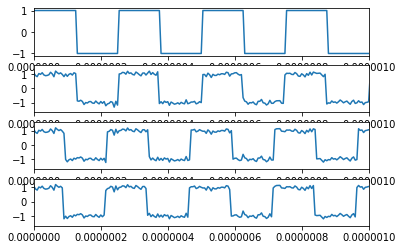

In [4]:
delay1 = vlc_obj.delays[0][1]*2
delay2 = vlc_obj.delays[1][1]*2

delays = [delay1, delay2] 
s_e, s_r, s_h = gen_signals(f, r, N, t, delays)
dm = estimate_dist(s_e, s_r, s_h, f, r, N, dt, t)

In [5]:
def dist_to_pos1(dm, delays, vlc_obj):
    l = vlc_obj.distancecar
    dr = dm['dr'] 
    dr_err = np.abs(vlc_obj.distances[0][1] - dr)
    dr = dr[dr_err == np.min(dr_err)][0]
    print("Distance: ", dr, "Error: ", np.min(dr_err))
    dl = dm['dl']
    dl_err = np.abs(vlc_obj.distances[1][1] - dl)
    dl = dl[dl_err == np.min(dl_err)][0]
    print("Distance: ", dl, "Error: ", np.min(dl_err))
    
    y = (dl**2 - dr**2 + l**2) / (2*l)
    print("y: ", y)
    x = -np.sqrt(dl**2 - y**2)
    print("x: ", x)
    
    return x,y

def dist_to_pos2(dm, delays, vlc_obj):
    l = vlc_obj.distancecar
    dr = dm['dr'] 
    dr_err = np.abs(vlc_obj.distances[0][0] - dr)
    dr = dr[dr_err == np.min(dr_err)][0]
    print("Distance: ", dr, "Error: ", np.min(dr_err))
    dl = dm['dl'] 
    dl_err = np.abs(vlc_obj.distances[1][0] - dl)
    dl = dl[dl_err == np.min(dl_err)][0]
    print("Distance: ", dl, "Error: ", np.min(dl_err))
    
    y = (dl**2 - dr**2 + l**2) / (2*l)
    print("y: ", y)
    x = -np.sqrt(dl**2 - y**2)
    print("x: ", x)
    
    return x,y

In [6]:
x, y = dist_to_pos1(dm, delays, vlc_obj)

print("Coords: ")
print("(", x,  ", ", y, ")")

Distance:  5.085 Error:  0.014019513592784527
Distance:  5.37 Error:  0.015164807134503633
y:  1.9898375000000001
x:  -4.987729616127337
Coords: 
( -4.987729616127337 ,  1.9898375000000001 )


Distance:  5.37 Error:  0.015164807134503633
Distance:  5.835 Error:  0.004048105154699222
y:  3.1051624999999987
x:  -4.940161014440092
Coords: 
( -4.940161014440092 ,  3.1051624999999987 )


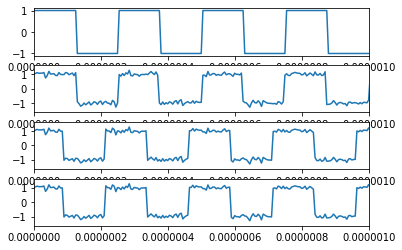

In [7]:
delay1 = vlc_obj.delays[0][0]*2
delay2 = vlc_obj.delays[1][0]*2

delays = [delay1, delay2] 
s_e, s_r, s_h = gen_signals(f, r, N, t, delays)
dm = estimate_dist(s_e, s_r, s_h, f, r, N, dt, t)

x, y = dist_to_pos2(dm, delays, vlc_obj)

print("Coords: ")
print("(", x,  ", ", y, ")")